In [1]:
import torch, torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [2]:
# set environemtn PYTORCH_ENABLE_MPS_FALLBACK=1
device = "cpu"
# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")

# else:
#     device = torch.device("mps")

device

'cpu'

In [3]:
T = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])
train_set = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
print(train_set)
test_set = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
BATCH_SIZE = 64
train_dl = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_set, batch_size = 1, shuffle=True)

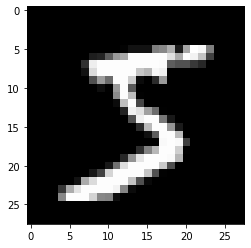

In [5]:
plt.imshow(train_set[0][0][0], cmap="gray")

# Variational Auto Encoder


In [6]:
class MNIST_VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.kl = 0
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
            
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )

        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
        )

        self.bottleneck1 = nn.Linear(128, 2)
        self.bottleneck2 = nn.Linear(128, 2)

        self.decoder_dense = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),
            nn.Unflatten(1, [32, 3, 3])
        )

        self.decoder_maxunpool = nn.MaxUnpool2d(2)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoder_conv = self.encoder_conv(x)
        encoder_dense = self.encoder_dense(encoder_conv)

        mu = self.bottleneck1(encoder_dense)
        sigma = torch.exp(self.bottleneck2(encoder_dense))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        decoder_dense = self.decoder_dense(z)
        decoder_conv = self.decoder_conv(decoder_dense)
        return decoder_conv, z


In [7]:
# INSTANTIATE NEW
LOAD = False
vae = None
if LOAD:
  vae = torch.load("vae.pt")
  print(vae.eval())
else:
  vae = MNIST_VAE()
  print(vae.eval())


MNIST_VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=128, bias=True)
    (2): ReLU()
  )
  (bottleneck1): Linear(in_features=128, out_features=2, bias=True)
  (bottleneck2): Linear(in_features=128, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=[32, 

  0%|          | 0/200 [00:00<?, ?it/s]

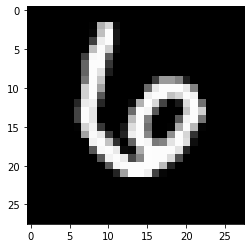

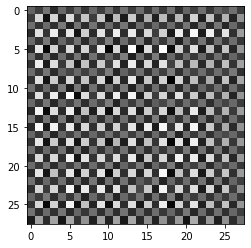

13605.025390625


  2%|▎         | 5/200 [01:07<43:19, 13.33s/it]

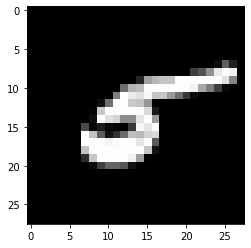

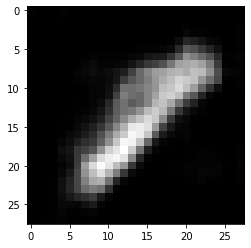

2499.5224609375


  5%|▌         | 10/200 [02:15<43:02, 13.59s/it]

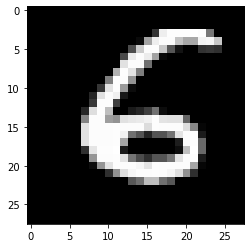

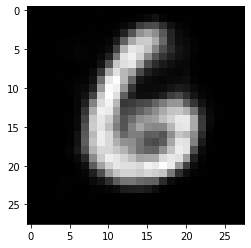

2493.968017578125


  8%|▊         | 15/200 [03:22<41:17, 13.39s/it]

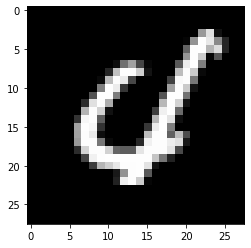

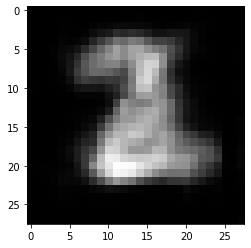

2557.998779296875


 10%|█         | 20/200 [04:30<40:27, 13.49s/it]

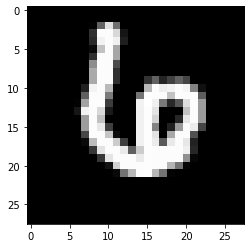

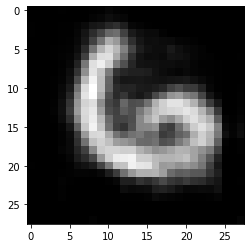

2266.0625


 12%|█▎        | 25/200 [05:36<38:54, 13.34s/it]

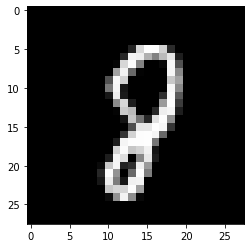

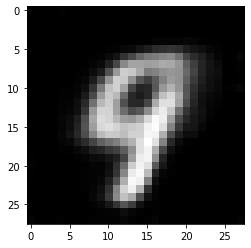

2590.35107421875


 15%|█▌        | 30/200 [06:45<38:15, 13.51s/it]

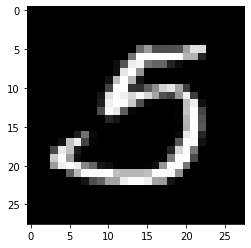

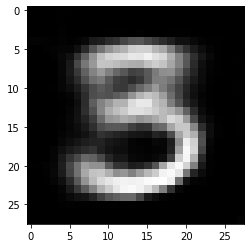

2233.388427734375


 18%|█▊        | 35/200 [07:53<37:31, 13.64s/it]

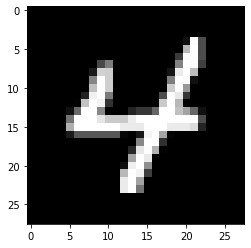

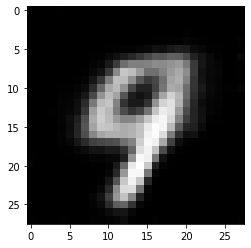

2215.46435546875


 20%|██        | 40/200 [08:59<34:48, 13.05s/it]

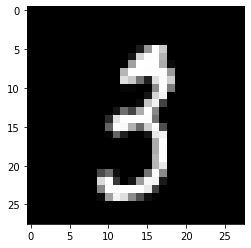

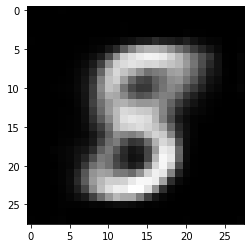

2292.24560546875


 22%|██▎       | 45/200 [10:03<33:01, 12.79s/it]

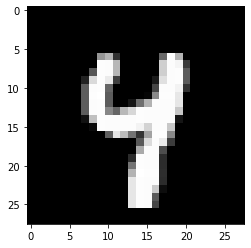

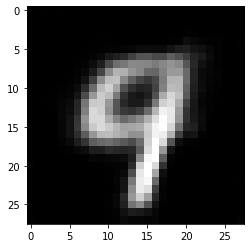

2276.232177734375


 25%|██▌       | 50/200 [11:09<33:04, 13.23s/it]

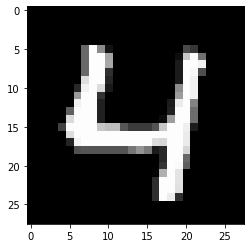

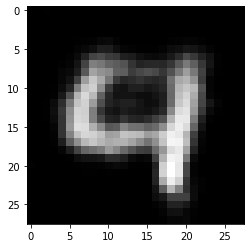

2290.823486328125


 28%|██▊       | 55/200 [12:16<32:23, 13.40s/it]

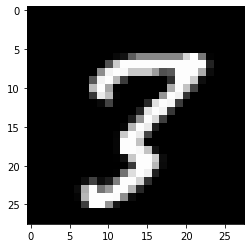

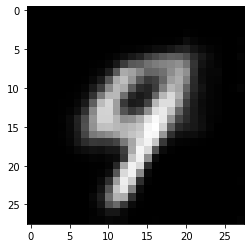

2398.9033203125


 30%|███       | 60/200 [13:23<31:00, 13.29s/it]

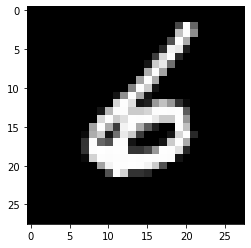

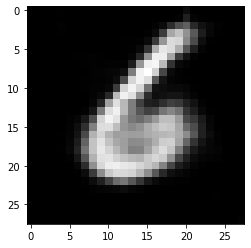

2229.2578125


 32%|███▎      | 65/200 [14:30<29:48, 13.25s/it]

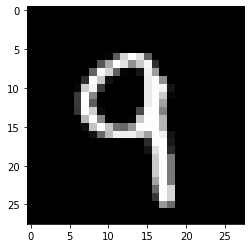

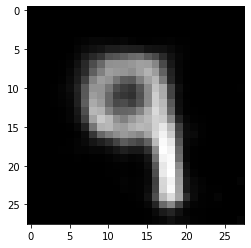

2101.084716796875


 35%|███▌      | 70/200 [15:37<28:43, 13.26s/it]

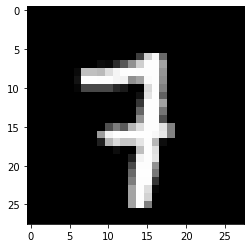

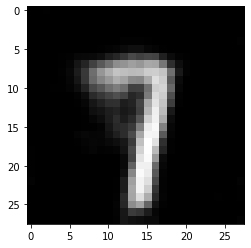

2249.050048828125


 38%|███▊      | 75/200 [16:43<27:26, 13.17s/it]

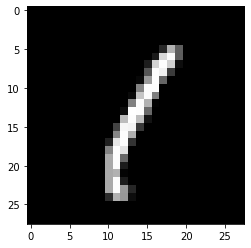

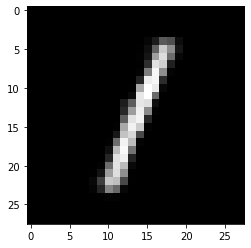

2104.513427734375


 40%|████      | 80/200 [17:50<26:50, 13.42s/it]

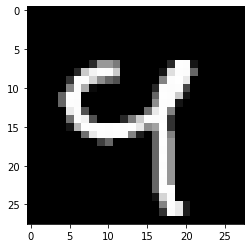

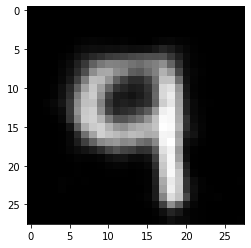

2210.6455078125


 42%|████▎     | 85/200 [18:57<25:32, 13.33s/it]

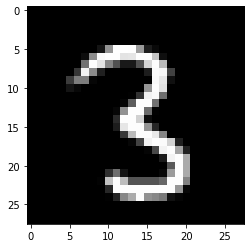

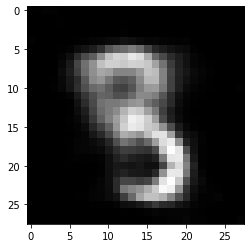

2352.921875


 45%|████▌     | 90/200 [20:05<24:44, 13.49s/it]

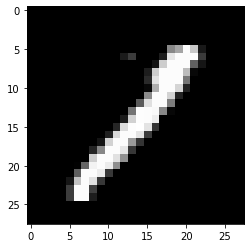

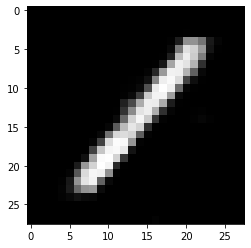

2244.831298828125


 48%|████▊     | 95/200 [21:13<23:40, 13.53s/it]

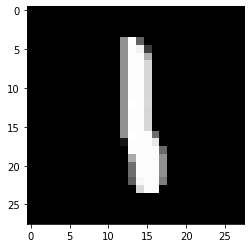

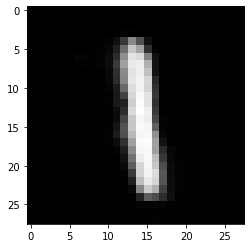

2152.3154296875


 50%|█████     | 100/200 [22:23<23:09, 13.90s/it]

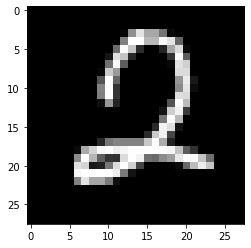

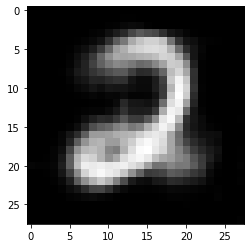

2509.286376953125


 52%|█████▎    | 105/200 [23:30<21:26, 13.54s/it]

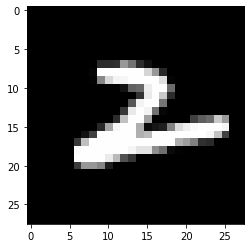

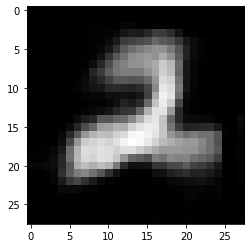

2239.6005859375


 55%|█████▌    | 110/200 [24:38<20:31, 13.69s/it]

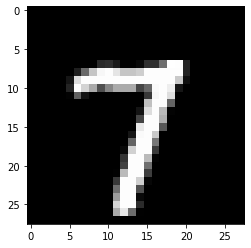

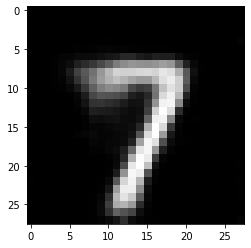

2264.53662109375


 57%|█████▊    | 115/200 [25:45<18:59, 13.41s/it]

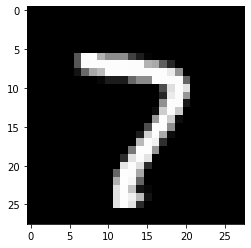

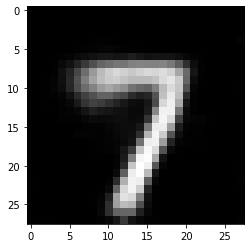

2098.24267578125


 60%|██████    | 120/200 [26:53<18:05, 13.56s/it]

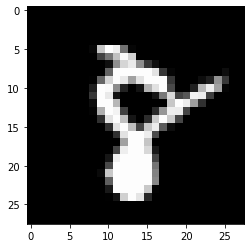

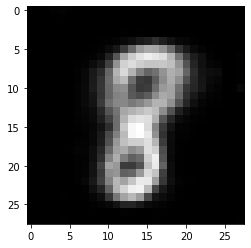

2208.513671875


 62%|██████▎   | 125/200 [28:01<16:57, 13.56s/it]

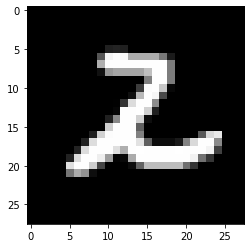

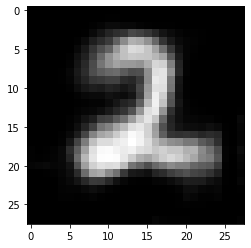

2317.934326171875


 65%|██████▌   | 130/200 [29:08<15:37, 13.40s/it]

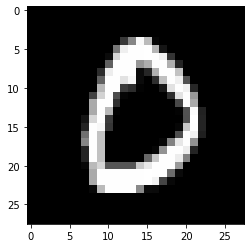

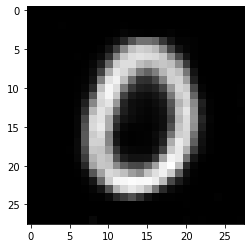

2347.58349609375


 68%|██████▊   | 135/200 [30:16<14:44, 13.61s/it]

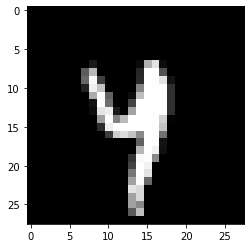

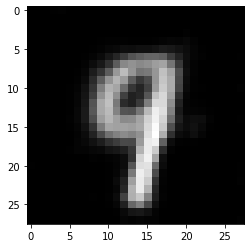

2220.632080078125


 70%|███████   | 140/200 [31:26<14:22, 14.38s/it]

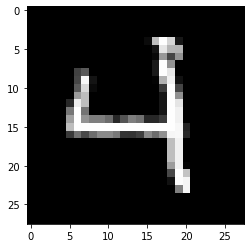

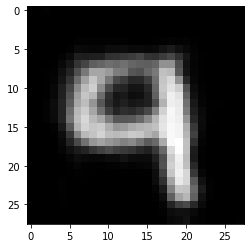

2222.97802734375


 72%|███████▎  | 145/200 [32:36<12:45, 13.92s/it]

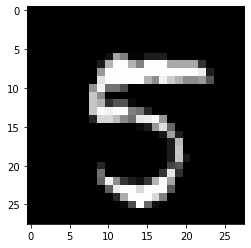

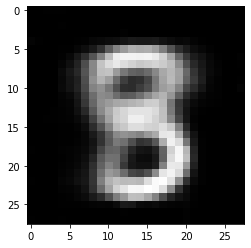

2295.8154296875


 75%|███████▌  | 150/200 [33:43<11:17, 13.56s/it]

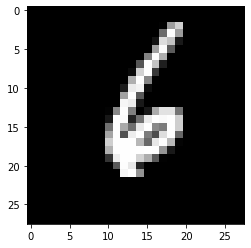

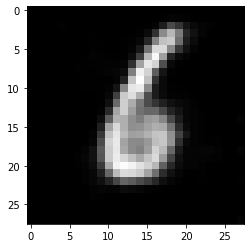

2430.4541015625


 78%|███████▊  | 155/200 [34:51<10:14, 13.65s/it]

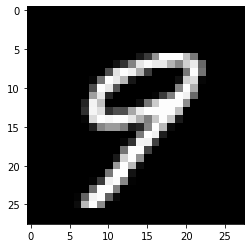

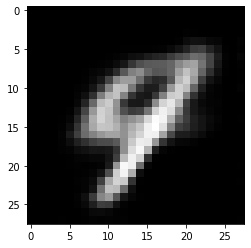

2421.1083984375


 80%|████████  | 160/200 [36:00<09:07, 13.70s/it]

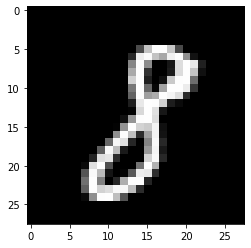

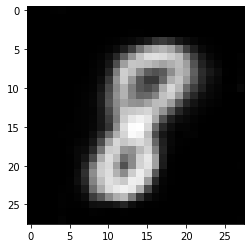

2051.978515625


 82%|████████▎ | 165/200 [37:07<07:53, 13.54s/it]

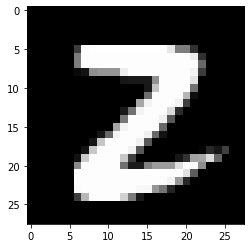

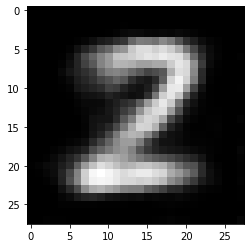

2072.05908203125


 85%|████████▌ | 170/200 [38:12<06:34, 13.15s/it]

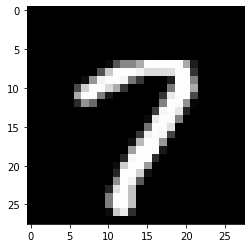

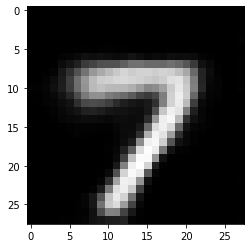

2127.080810546875


 88%|████████▊ | 175/200 [39:19<05:34, 13.39s/it]

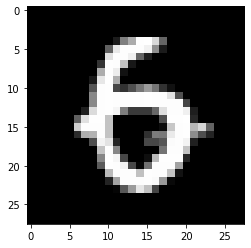

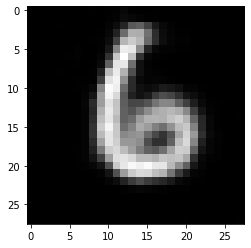

2256.2412109375


 90%|█████████ | 180/200 [40:26<04:26, 13.30s/it]

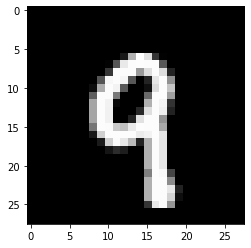

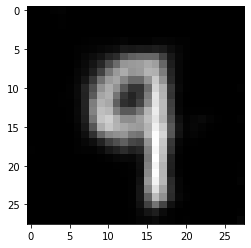

2164.663330078125


 92%|█████████▎| 185/200 [41:32<03:19, 13.29s/it]

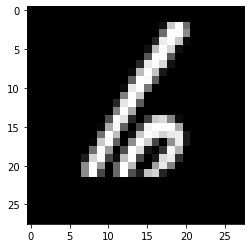

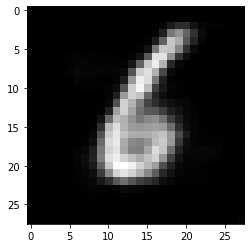

2375.77587890625


 95%|█████████▌| 190/200 [42:40<02:15, 13.53s/it]

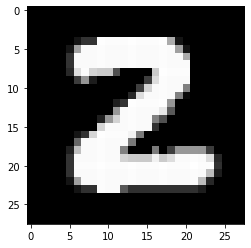

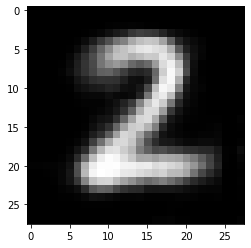

2219.00048828125


 98%|█████████▊| 195/200 [43:47<01:06, 13.33s/it]

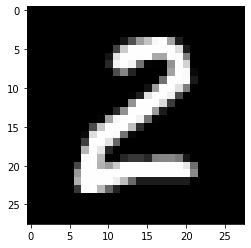

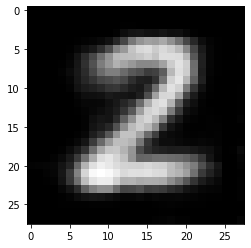

2182.645751953125


100%|██████████| 200/200 [44:56<00:00, 13.48s/it]


In [8]:
torch.manual_seed(0)

EPOCHS = 200
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    labels = labels.to(device)
    pred, bottlenecked = vae(images)

    

    #MSE & KL
    loss = ((images - pred)**2).sum() + vae.kl
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
    #DISPLAY IMAGE
    if j == 0 and i % 5 == 0:
      plt.imshow(torch.squeeze(images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()
      print(sum_loss/ctr)

torch.save(vae, "vae.pt")

In [9]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
       _, encoded_img  = vae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:04<00:00, 2339.00it/s]


In [10]:
def plot_ae_outputs(vae ,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
      with torch.no_grad():
         rec_img, _  = vae(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

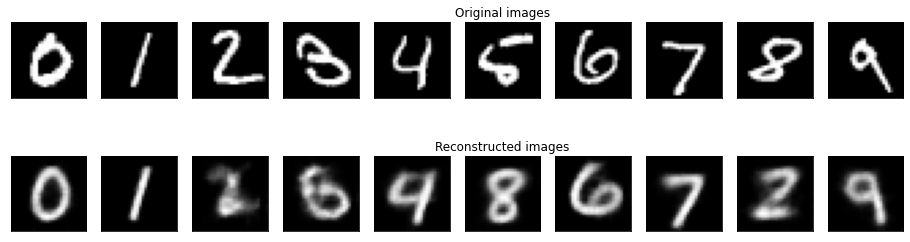

In [11]:
plot_ae_outputs(vae)